# Training a Random Forest Model over a CORINE Dataset using Google Earth Engine with the Python API 

This notebook demonstrates how to train a random forest model over a CORINE dataset using Google Earth Engine with the Python API. The goal is to classify land cover categories based on the CORINE data and create decision trees using the random forest algorithm. We will also use geemap to visualize the results and save the decision trees locally.

The workflow consists of the following steps:

1. Set up the environment by importing the necessary libraries and authenticating our Earth Engine account.

2. Defining the study area via GEE asset (table or shapefile)

3. Looping through the years, training over the relevant Corine data

4. Returning the created decision trees with accuracy assesment detail. 

Saving the classifier will allow to classify a more continuous timeseries. 

## Useful to know

- Here the classifiers are saved locally for re-use. Unfortunately due to server limits, a trained model cannot exceed 10MB before memory limits are encountered. 

- The underlying landsat timeseries is created using an adaptation of the landTrendr module, adapted and simplified here for efficiency. It accomplishes, creating the image series and band calculation. This version uses the latest processing efforts of the Landsat TM+ ETM+ and OLI collection 2


The classification routine has been implemented here by Mike O'Hanrahan for their MSc graduation thesis project.

In [21]:
import ee
import geemap
import geemap.ml as ml
from ipygee import chart as chart
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from datetime import datetime as dt
import datetime
import pytz

In [22]:
today = dt.today()
print("Today is: ", today)

Today is:  2023-04-18 14:38:47.002324


## GEE Authentication

Before using the Earth Engine Python API, we need to authenticate our account. The authentication step is required for the first time you use Earth Engine in a new session and roughly every week thereafter.

To authenticate, run the following cell and follow the prompts to log into your Earth Engine account. You will then be prompted to copy and paste the authentication code into the box provided. Once you have pasted the code, press enter to save the token.


In [3]:
# ee.Authenticate()
geemap.ee_initialize()

## Hydroclimatic Information

The code below defines a list of catchment names for Belgium and France by reading Excel files and concatenating them together. It then defines a function to remove whitespace at the end of each catchment name. Finally, it applies this function to each catchment name in the list, and prints out the total number of catchments and the resulting list of cleaned catchment names.

In [9]:
p = '..'

l_BE = pd.read_excel(f"{p}\Inputs\Version_3_20230303\BE.xlsx").catchment.tolist()
l_FR = pd.read_excel(f"{p}\Inputs\Version_3_20230303\FR.xlsx").catchment.tolist()

ls = l_BE+l_FR

def drop_space(i) -> str:
    '''
    Since the FR and BE data is given with indices using catchment names,
    it is necessary to check and drop the space at the end of each name where applicable.
    
    list the letters, check the last charachter and delete if necessary. 
    '''
    
    ls = list(i)
    
    if ls[-1] == ' ':
        i = i[:-1]
    else:
        i = i
    return i


names = [drop_space(i) for i in ls]

print(f'{len(names)} catchments processed for hydroclimatic variables:\n \n{names}')

22 catchments processed for hydroclimatic variables:
 
['Membre Pont', 'Straimont', 'Treignes', 'Chooz', 'Daverdisse', 'Jemelle', 'Hastiere', 'Warnant', 'Ortho', 'Wiheries', 'Salzinnes', 'Huccorgne', 'Amay', 'La Meuse Goncourt', 'Le Mouzon Circourt-sur-Mouzon [Villars]', 'Le Vair Soulosse-sous-Saint-Élophe', 'La Meuse Saint-Mihiel', 'La Meuse Stenay', 'La Chiers Longlaville', 'La Chiers Carignan', 'La Bar Cheveuges', 'La Vence la Francheville']


## Load the EE package

This notebook uses an adapted landTrendr package to construct time series of Landsat imagery for land cover detection. The package is optimized for deforestation event detection and can be used with the latest version of landTrendr available in the GEE asset, which has an Apache license and is free to use.

To load the package, we use the ltgee.buildSRcollection method. Note that if the JavaScript module is faulty, the cell below will not load.

In [10]:
oeel = geemap.requireJS()

Map = geemap.Map()

ltgee = geemap.requireJS(r'../JS_module/Adapted_LT_v6.js')

#ltgee.availability  #all functions within the javascript module

## Initiate With a Shapefile

This notebook assumes the user has a shapefile saved as an asset on their GEE, the assets used in the CATAPUCII project will be made publicly available in the @mohanrahan repository

Assigning some useful variables for later classification

Catchment Assets are available at this address:

https://code.earthengine.google.com/?asset=projects/mohanrahan/assets/CATAPUCII_Catchments


## Assigning useful variables

- The asset_dir will point to the shapefile loaded as a GEE table asset. 
- crs is important for reprojection and scaling (which will affect area calculations)
- RGB_VIS is for landsat RGB visual parameters
- start day defines the beginning of the seasonal composite period
- maskThese applies a mask (renders Null/NA/Transparent) to those majority pixels in landsat imagery

In [11]:
asset_dir = 'CATAPUCII_Catchments/Meuse_Catchments_4326_WFLOW'

dataset = 'Meuse'

crs = 'EPSG:4326'

fignum = 0

RGB_VIS = {'bands':['B3','B2','B1'], 'min':0, 'max':1.5e3}

startYear = 1984

endYear = 2022

startDay = '06-20'

endDay = '08-31'

maskThese = ['cloud', 'shadow', 'snow',]

bandList = ["B1", "B2", "B3", "B4", "B5", "B7", 
           'NBR', 'NDMI', 'NDVI', 'NDSI', 'EVI','GNDVI', 
           'TCB', 'TCG', 'TCW', 'TCA', 'NDFI',] 


## Load and filter the table data 

- The code loads a FeatureCollection from a Google Earth Engine asset directory, using the ee.FeatureCollection method.
- It defines three functions to calculate the area of each geometry in square kilometer, set the system ID as a column, and calculate the pixel area.
- It applies these functions to the FeatureCollection using the map method, and saves the resulting FeatureCollection as table_area.
- It filters and sorts table_area to obtain only those features whose area_km2 is greater than 0 and sorts them by area_km2.
- It converts the resulting FeatureCollection to a pandas DataFrame using geemap.ee_to_pandas and sets the index to system_index.
- It selects the rows of the DataFrame whose station_re is in the names list and saves the resulting DataFrame as df1.
- It saves the entire DataFrame as an Excel file in a specified output directory, using the to_excel method.


Overall, the code processes a FeatureCollection from a Google Earth Engine asset directory, calculates various areas, filters and sorts the features, selects a subset of features based on a list of catchment names, and saves the resulting DataFrame as an Excel file.


In [12]:
table = ee.FeatureCollection(f"projects/mohanrahan/assets/{asset_dir}")

def set_area_km2(feature):
    '''
    Calculate the area of each geometry in square kilometer
    '''
    area = feature.geometry().area().divide(1000*1000)
    setting = feature.set('area_km2', area)
    return setting

def set_area_pixel(feature):
    aoi = feature.geometry()
    area = ee.Image.pixelArea().divide(1e6).clip(aoi).select('area').reduceRegion(**{
        'reducer':ee.Reducer.sum(),
        'geometry':aoi,
        'scale':30,
        'crs':'EPSG:4326',
        'maxPixels':1e13,
        'bestEffort':True,
        }).get('area')
    setting = feature.set('pixel_area', area)
    return setting

def set_id(feature):
    '''
    Set the system ID as a column
    '''
    getting_name = ee.String(feature.get('system:index'))
    setting_id = feature.set({'system_index':getting_name,})
    return setting_id

table_area = table.map(set_area_km2).map(set_id).map(set_area_pixel)

Filtered_Sorted = table_area.filter(ee.Filter.gt('area_km2', 0)).sort('area_km2', False)  # true ranks from smallest to largest

down = geemap.ee_to_pandas(Filtered_Sorted).set_index(['system_index'])

df1 = down.loc[down['station_re'].isin(names)]

sys_index = df1.index.to_list()

display(df1)

df1.loc[sys_index[-1]]

print(len(df1))


gdf = geemap.ee_to_pandas(Filtered_Sorted)

if not os.path.exists(f'../Outputs/{dataset}/'):
    os.makedirs(f'../Outputs/{dataset}/')

gdf.to_excel(f'../Outputs/{dataset}/{dataset}_catchment_table.xlsx', index=0)

,pixel_area,area_km2,station_Y_,wflowID,station_X_,station_re,station_na
system_index,,,,,,,
00000000000000000004,2681.514071,2672.267778,50.466667,9.0,4.835833,Salzinnes,Salzinnes Ronet
00000000000000000001,1471.943902,1467.021734,50.091667,4.0,4.810833,Chooz,Chooz
00000000000000000000,1368.127798,1363.749108,49.491667,3.0,5.177500,La Meuse Stenay,La Meuse Stenay
0000000000000000000d,1349.324088,1345.191904,48.866667,101.0,5.527500,La Meuse Saint-Mihiel,La Meuse Saint-Mihiel
00000000000000000022,1247.982599,1243.674956,50.533333,1401.0,5.319167,Amay,Amay
0000000000000000000e,1067.196654,1063.732496,49.633333,201.0,5.144167,La Chiers Carignan,La Chiers Carignan
00000000000000000002,913.747728,910.700030,49.866667,5.0,4.902500,Membre Pont,Membre Pont
00000000000000000003,550.486854,548.630959,50.091667,6.0,4.677500,Treignes,Treignes
00000000000000000021,440.093432,438.791674,48.400000,1016.0,5.735833,Le Vair Soulosse-sous-Saint-Élophe,Le Vair Soulosse-sous-Saint-Élophe


22


In [13]:
Map = geemap.Map()

Map.setOptions('TERRAIN')
Map.addLayer(Filtered_Sorted.filter(ee.Filter.inList('station_re', ee.List(names))), {'color': 'green'}, 'green: Included')
Map.addLayer(Filtered_Sorted.filter(ee.Filter.inList('station_re', ee.List(names)).Not()), {'color':'red'}, 'red: Not Included')
Map.centerObject(Filtered_Sorted, 7)


Map

Map(center=[50.15762767624681, 5.442982293509325], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [14]:
def clip_collection(image: ee.Image) -> ee.Image:
    '''
    Clip an image to the area of interest and return a copy of the clipped image.

    Input:
        image (ee.Image): the image to clip
    
    Output:
        ee.Image: the clipped image
    '''
    return image.clip(aoi).copyProperties(image)


def extractArea(item) -> ee.List:
    '''
    Extract the area of a classified land cover class as a list of class number and area.

    Input:
        item (ee.Dictionary): a dictionary containing classification and pixel area information
    
    Output:
        ee.List: a list of class number and area
    '''
    
    areaDict = ee.Dictionary(item)
    classNumber = ee.Number(areaDict.get('classification')).format()
    area = ee.Number(areaDict.get('sum')).divide(1e6)
    return ee.List([classNumber, area])


def classArea(classified_image: ee.Image, scale: int) -> ee.List:
    '''
    Calculate the area of each classified land cover class for an image at a given scale.

    Input:
        classified_image (ee.Image): classified image
        scale (int): scale of the image in meters
    
    Output:
        ee.List: a list of class numbers and areas for the image
    '''
    
    areaImage = ee.Image.pixelArea().addBands(classified_image)
    
    areas = areaImage.reduceRegion(**{
            'reducer':ee.Reducer.sum().group(**{'groupField':1, 'groupName':'classification'}),
            'geometry':aoi,
            'scale':scale,
            'maxPixels':1e10,
            'bestEffort':True,
    })
    
    classAreas = ee.List(areas.get('groups'))
    
    classAreasLists = classAreas.map(extractArea)
    
    return classAreasLists

def msToDate(milliseconds: int) -> datetime.datetime:
    '''
    Convert a timestamp in milliseconds to a datetime object.

    Input:
        milliseconds (int): a timestamp in milliseconds
    
    Output:
        datetime.datetime: a datetime object corresponding to the timestamp
    '''
    
    base_datetime = datetime.datetime(1970, 1, 1)
    delta = datetime.timedelta(0, 0, 0, milliseconds)
    target_datetime = base_datetime + delta
    return target_datetime

def dataframeAreas(i: int, yc: int, classified: ee.Image, trainingClassImage: ee.Image, ms: int, classImageYear: int, name: str, accuracy: float) -> pd.DataFrame:
    '''
    Calculate the area of each classified land cover class for an image, given its classification and training images, and return a DataFrame of the results.

    Input:
        i (int): index of the current image in the collection
        yc (int): year count (number of years since the first year in the collection)
        classified (ee.Image): classified image
        trainingClassImage (ee.Image): training image with land cover classes
        ms (int): timestamp of the image in milliseconds
        classImageYear (int): year of the image used for classification
        name (str): name of the catchment
        accuracy (float): accuracy of the classifier used for classification
    
    Output:
        pivoted (pd.DataFrame): a pivoted DataFrame with columns representing land cover classes and rows representing image dates, area of each class for CORINE and random forest classifications, and catchment name, training year, and accuracy information
    '''
    
    ls1 = pd.DataFrame(classArea(classified, 30).getInfo(), columns=['class', 'area_RF'])
    ls2 = pd.DataFrame(classArea(trainingClassImage, 100).getInfo(), columns=['class', 'area_CORINE'])

    merged = ls1.merge(ls2, how='inner', on='class')
    merged['image_date'] = ms
    pivoted = merged.pivot(index='image_date', columns='class', values=['area_CORINE', 'area_RF'])
    pivoted['training', 'year_trained'] =  classImageYear
    pivoted['area_CORINE', '6'] = 0
    pivoted['catchment', 'area'] = pivoted.iloc[0, 0:5].sum()
    pivoted['area_RF', '6'] = pivoted.catchment.area - pivoted.iloc[0, 6:10].sum() 
    pivoted['catchment', 'name '] = name
    pivoted['testing', 'accuracy'] = accuracy
    pivoted['ind'] = str(i)+'_'+str(yc)
    pivoted.fillna(0)
    
    return pivoted


    
def saveClassifierToCSV(classifier: ee.Classifier, name: str, yc: int) -> None:
    '''
    Save decision trees from a random forest classifier to CSV files.

    Input:
        classifier (ee.Classifier): a trained random forest classifier
        name (str): name of the catchment
        yc (int): year count (number of years since the first year in the collection)
    
    Output:
        None
    '''
    
    decisionTrees = ee.List(classifier.explain().get('trees')).getInfo()
    folder='Trees'
    
    print('saving...')

    var = f'../Outputs/{dataset}/{folder}/'

    if not os.path.exists(var):
        print('created')
        os.makedirs(var)

    ml.trees_to_csv(decisionTrees, f'../Outputs/Meuse/Trees/{name}_{yc}')


In [15]:
id_ls = 'used_images'
SR_t = 'SR_timeseries'
RF_c = 'RF_classification/'


folder_list = [id_ls, SR_t, RF_c]

for folder in folder_list:
    
    '''
    Create output folders if they don't exist.

    Input:
        folder (str): the name of the folder to create
    
    Output:
        None
    '''
    
    var = f'../Outputs/{dataset}/{folder}'
    
    if not os.path.exists(var):
        print('created')
        os.makedirs(var)



### areas calculated from: 

https://code.earthengine.google.com/cc1f2371404daf318b08060def5a1aa5

- This code defines a list of land cover class names and three dictionaries of land cover class areas in square kilometers for different regions of interest. 
- It then extracts the trained area in square kilometers from the area_for_weighted_sample dictionary and calculates the total. 
- It calculates the percentage of each land cover class within the total trained area and a weight for each land cover class based on its percentage of the total trained area. 
- Finally, it prints the weights for each land cover class to the console.

In [17]:
# Define a list of land cover class names
class_names = ['Artificial', 'Agricultural', 'Forest and Semi-Natural', 'Wetlands', 'Waterbodies']

# Define dictionaries of land cover class areas in square kilometers for different regions of interest
area_22_catchment = {"1": 1272.5302137428105, "2": 7980.776893726768, "3": 5614.751890457247, "4": 8.40213411897978, "5": 53.69054158948903}

# The area as calculated from the full basin including the catchments outside of the classification area
meuse_area_full_basin = {"1": 3515.899739181923, "2": 15462.989230419153, "3": 9362.388401473556, "4": 67.76015865491058, "5": 176.2453267149072}
area_for_weighted_sample = meuse_area_full_basin

# Extract the trained area in square kilometers from the area_for_weighted_sample dictionary and calculate the total
trained_area_km = [area_for_weighted_sample[i] for i in area_for_weighted_sample.keys()]
tot = np.sum(trained_area_km)

# Calculate the percentage of each land cover class within the total trained area
area_full_pct = np.array([area_for_weighted_sample[i] / tot for i in area_for_weighted_sample.keys()])

# Calculate a weight for each land cover class based on its percentage of the total trained area
weights = [int(p * 5000) for p in area_full_pct]

# Print the weights for each land cover class to the console
weight_zip = zip(class_names, weights)
print(f'Points from percentage area:\n{[(cla, point) for cla, point in weight_zip]}')
print(area_full_pct)

Points from percentage area:
[('Artificial', 614), ('Agricultural', 2704), ('Forest and Semi-Natural', 1637), ('Wetlands', 11), ('Waterbodies', 30)]
[0.12299685 0.54094232 0.32752478 0.00237046 0.0061656 ]


## Defining the name of the output
- This will dictate whether the distribution of points is weighted and or tuned



In [18]:
# saved_classifier_name = 'Meuse_Max_untuned_balanced'
# saved_classifier_name = 'Meuse_Max_untuned'
saved_classifier_name = 'Meuse_HC_tuned'

## The Random Forest has several hyperparameters that can be tuned

- These are passed via a dictionary and are determined via tuning in another notebook
- 

In [19]:
hyperparameters = {
    'number_of_trees':120,
    'variables_per_split':8,
    'minimum_leaf_population':1,
    'bag_fraction':0.6,
    'max_nodes':330,
    'seed':0
}


classLoopParams = {'dataset':'CORINE',    #training dataset, no other than corine currently supported
               'trainingClassLevel':1, #classLevel determines the level of corine class simplification
               'customClassLevels':None,   #can provide some custom levels, not fully tested
               'numClasses':5,            #if trainingClassLevel is 1 then there are 5 classes, level is 2 then there are 15, 3 is 44. (CORINE land cover class grouping)
               'split':0.7,               #split the training and testing 0.7/0.3 (70% training, 30% accuracy testing). 
               'tileScale':2,            #tileScale higher number reduces likelihood of classifier running into a memory limit
                'distribution':'weighted',  # can be weighted or balanced, weighting is done be area proportion
               'weighting':list(area_full_pct),  # weighting based on area, percentages are passed , dictionaries do not pass to javascript code as well as lists
               'year_classified': [1990, 2000, 2006, 2012, 2018],   # classification year is , for classifiers saved, the same as the years available in the training dataset
                'hyperparameters': [hyperparameters['number_of_trees'],
                                   hyperparameters['variables_per_split'],
                                   hyperparameters['minimum_leaf_population'],
                                   hyperparameters['bag_fraction'],
                                    hyperparameters['max_nodes'],
                                   hyperparameters['seed']] #hyperparameters are passed to  via a list, not a dictionary. 
              }


## This loop is set to generate all classifiers, it will output CSV classifiers

CSV classifiers save locally for all available training years in the corine dataset (or years set by the year classified loop parameter). The training area is the combined geometry of the whole meuse basin and are uploaded from client to server in the form of a decision Tree Ensemble. 

- Creating the classifier we also need to generate the training accuracy assessing  "" confusion matrix ""

from the confusion matrix: (overall) accuracy, kappa coefficient, producer's accuracy, consumers'accuracy. 

This will be assessed three times in the report, from a 

1. balanced non-tuned () [1990, 2000, 2006, 2012, 2018]
2. then weighted, non-tuned
3. then a weighted tuned classifier

In [16]:
t0 = dt.today()

confusion_matrices = []

error_matrices = []

accuracy_dictionaries = []

classArea_df = pd.DataFrame()

validation_combined_df = pd.DataFrame()

print(f'begin loop: {t0}')

aoi = Filtered_Sorted.filter(ee.Filter.inList('station_re', names))


for i, ind in enumerate(sys_index):
    
    area = df1.loc[ind].area_km2
    
    t1 = dt.today()
    
    name = saved_classifier_name
    
    print(f'{t1}\nDataset: {dataset}, \nCatchment: {name}, \nSurface Reflectance Processing ...\n')
    
    annual_med = ltgee.buildSRcollection(startYear, endYear, startDay, endDay, aoi, maskThese, [''])#.map(clip_collection) #much slower when clipped
    
    annual_med_calc = ltgee.transformSRcollection(annual_med, bandList)

    t3 = dt.today()
    
    print(f'\nstep 2: Initialize classification routine: {t3}')
    
    if dataset == 'Meuse':
        '''
        
        The years that we train on are not necessarily the same as the years we classify: 
        - first define the years to return that will be relevant to the decadal analysis (matching the hydroclimatic decades)
        - Then use conditions to define which training set corresponds best to the image to be classified. 
        - LATER: Will need to use a trained classifier, perhaps the 'best performer', to classify the USA dataset. 
            - Best accuracy may be to take a classifier that samples all 4 categories
        
        '''
        
        if saved_classifier_name[-7:]=='untuned' or saved_classifier_name[-8-8:]=='untuned_balanced':
            tuned = 'not_tuned'
            print('not_tuned classifier')
        else:
            tuned = 'tuned'
            print('classifier is tuned')
        
        
        
        for j, yc in enumerate(classLoopParams['year_classified']):
            '''
            Define the training image, then the image to classify, adding slope and elevation bands

            Corine Representative Classes:
            || 1989 -> 1998 | 1999 -> 2001 | 2005 -> 2007 | 2011 -> 2012 | 2017 -> 2018 ||
            ||   "1990"     |    "2000"    |    "2006"    |     "2012"   |     "2018"   ||

            Training "image year above" --> classify the relevant Landsat date range below:
            || 1984 -> 1998 | 1999 -> 2003 | 2004 -> 2009 | 2010 -> 2014 | 2015 -> ...  || 
            
            '''
            if yc >= 1984 and yc < 1999:
                classImageYear = 1990

            elif yc >= 1999 and yc < 2004:
                classImageYear = 2000

            elif yc >= 2004 and yc < 2010:
                classImageYear = 2006

            elif yc >= 2010 and yc < 2015:
                classImageYear = 2012

            elif yc >= 2015:
                classImageYear = 2018

            else:
                print('ERROR: year to classify out of range[1984 +]')
                break
            
            print('year classified', yc)
            
            #the image from the collection that we want to classify
            imageFromCollection = ee.ImageCollection(annual_med_calc).filterDate(str(yc)+'-'+startDay, str(yc+1)+'-'+endDay).first()
            
            #image from training dataset e.g. CORINE is selected and simlified... 
            trainingClassImage = ltgee.createTrainingImage(str(classImageYear), 
                                                           classLoopParams['dataset'], 
                                                           classLoopParams['trainingClassLevel'], 
                                                           aoi)
            
            
            #TODO: reproject to 30m native resolution
            clipped = imageFromCollection.clip(aoi)
            
            #Adding the elevation and slope band calculations to each image
            print('Adding Terrain...')
            imageToClassify = ltgee.addTerrainBand(clipped, aoi)
        
            
            #getting the date of the image and converting it from milliseconds since 1970 (Earth engines preferred datetime)
            ms = msToDate(ee.Date(imageToClassify.get('system:time_start')).getInfo()['value'])
            
            print('Generating GCP...')
            #the points used for training the classifier are randomly distibuted amongst the classes extracting a profile of spectral and terrain
            points = ltgee.genGCP(trainingClassImage, 
                                  imageToClassify, 
                                  classLoopParams['numClasses'], #set at 5 usually
                                  classLoopParams['split'],      #set at 70/30
                                  classLoopParams['tileScale'], 
                                  aoi, 
                                  classLoopParams['distribution'], #either balanced or weighted
                                  classLoopParams['weighting'])
            
            
            # 70% of the points are allocated to training
            training = points['training']
            
            # 30% of the points are allocated to classification
            testing = points['testing']
            
            t5 = dt.today()
            
            print('Building classifier...')
            
            #classifier training with predefined number of trees using training points
            classifier = ltgee.classifier(imageToClassify, training, tuned, classLoopParams['hyperparameters'])
            
            t6 = dt.today()
            
            #saving decision trees for later use
            saveClassifierToCSV(classifier, name, yc)
            
            '''
            Accuracy metrics saved, firstly the testing metrics, generated via the confusion matrix, then similarly the Validation accuracy metrics (from the 30% split test). 
            A dataframe is generated, populated with the overall accuracy, kappa score, fscore, producers accuracy and consumers accuracy. 
            
            The matrices (confusion/training & error/validation) are saved as individual npy files, and upon completion of a complete loop the list of all matrices are saved as a combined list of matrices. 
            
            '''
            
            print('Asessing classifier accuracy...')
            
            confusion_matrix = classifier.confusionMatrix()
            
            cm = np.array(confusion_matrix.getInfo())[1:, 1:]
            
            accuracy = confusion_matrix.accuracy().getInfo()
            
            kappa = confusion_matrix.kappa().getInfo()
            
            fscore = confusion_matrix.fscore(1).getInfo() #beta is one, the precision and recall are equally important
            
            producers_accuracy = confusion_matrix.producersAccuracy().getInfo()
            
            consumers_accuracy = confusion_matrix.consumersAccuracy().getInfo()
            
            np.save(f'../Outputs/{dataset}/Trees/{saved_classifier_name}_{tuned}_confusionMatrix_{classImageYear}.npy', arr=cm, allow_pickle=True)   #saving the confusionMatrix to allow for later access in assessing the bias
            
            confusion_matrices.append(cm)

            acc_dict = {'train_valid':'training',
                        'tree_name':f'{saved_classifier_name}_{tuned}',
                        'year':classImageYear, 
                        'o_accuracy':accuracy,
                        'kappa':kappa,
                        'fscore1':fscore[1],
                        'fscore2':fscore[2],
                        'fscore3':fscore[3],
                        'fscore4':fscore[4],
                        'fscore5':fscore[5],
                        'p_accuracy1':producers_accuracy[1][0],
                        'p_accuracy2':producers_accuracy[2][0],
                        'p_accuracy3':producers_accuracy[3][0],
                        'p_accuracy4':producers_accuracy[4][0],
                        'p_accuracy5':producers_accuracy[5][0],
                        'c_accuracy1':consumers_accuracy[0][1],
                       'c_accuracy2':consumers_accuracy[0][2],
                       'c_accuracy3':consumers_accuracy[0][3],
                       'c_accuracy4':consumers_accuracy[0][4],
                       'c_accuracy5':consumers_accuracy[0][5]}
            
            acc_df = pd.DataFrame(acc_dict, index=[0])
            acc_df.to_excel(f'../Outputs/{dataset}/Trees/{saved_classifier_name}_{tuned}_accuracy_metrics_{classImageYear}.xlsx')
            
            importance = ee.Dictionary(classifier.explain()).get('importance').getInfo()
            
            validation_combined_df = validation_combined_df.append(acc_df)
            
            pd.DataFrame(importance, index=[0]).to_excel(f'../Outputs/{dataset}/Trees/{saved_classifier_name}_{tuned}_importance_{classImageYear}.xlsx')
            
            '''
            Validation metrics saved
            '''
            
            print('Asessing classifier validation accuracy...')
            
            validated = testing.classify(classifier)
            
            test_matrix = validated.errorMatrix('landcover', 'classification')
            
            em = np.array(test_matrix.getInfo())[1:,1:]
            
            error_matrices.append(em)
            
            accuracy = test_matrix.accuracy().getInfo()
            
            kappa = test_matrix.kappa().getInfo()
            
            fscore = test_matrix.fscore(1).getInfo() #beta is one, the precision and recall are equally important
            
            producers_accuracy = test_matrix.producersAccuracy().getInfo()
            
            consumers_accuracy = test_matrix.consumersAccuracy().getInfo()
            
            error_matrices.append(em)
            
            print('error_matrices', em)
            

            val_dict = {'train_valid':'validation',
                        'tree_name':f'{saved_classifier_name}_{tuned}',
                        'year':classImageYear, 
                        'o_accuracy':accuracy,
                        'kappa':kappa,
                        'fscore1':fscore[1],
                        'fscore2':fscore[2],
                        'fscore3':fscore[3],
                        'fscore4':fscore[4],
                        'fscore5':fscore[5],
                        'p_accuracy1':producers_accuracy[1][0],
                        'p_accuracy2':producers_accuracy[2][0],
                        'p_accuracy3':producers_accuracy[3][0],
                        'p_accuracy4':producers_accuracy[4][0],
                        'p_accuracy5':producers_accuracy[5][0],
                        'c_accuracy1':consumers_accuracy[0][1],
                       'c_accuracy2':consumers_accuracy[0][2],
                       'c_accuracy3':consumers_accuracy[0][3],
                       'c_accuracy4':consumers_accuracy[0][4],
                       'c_accuracy5':consumers_accuracy[0][5]}
                        
            val_df = pd.DataFrame(val_dict, index=[0])
            
            val_df.to_excel(f'../Outputs/{dataset}/Trees/{saved_classifier_name}_{tuned}_validation_metrics_{classImageYear}.xlsx')
            
            np.save(f'../Outputs/{dataset}/Trees/{saved_classifier_name}_{tuned}_validationMatrix_{classImageYear}.npy', arr=em, allow_pickle=True)   #saving the confusionMatrix to allow for later access in assessing the bias
            
            print('Classifying...')
            
            classified = imageToClassify.classify(classifier)

            df = dataframeAreas(i, j, classified, trainingClassImage, ms, classImageYear, f'{saved_classifier_name}_{tuned}', accuracy)
                       
            classArea_df = classArea_df.append(df)
            
            validation_combined_df = validation_combined_df.append(val_df)
            
            t2 = dt.today()
            
            print(f'time for {classImageYear} data = {t2 - t3}')
            
    else:
        print('classification routine for this dataset is not yet provided for')
    
    t4 = dt.today()
    print(f'step2: Done: {t4}, time taken: {t4-t3}')
    print(f'\nCatchment: {name}, total time: {t4-t1}\n---------------')
    
    if ind == sys_index[0]:
        break

classArea_df.to_excel(f'../Outputs/{dataset}/RF_classification/{saved_classifier_name}_{tuned}_combinedAreas.xlsx')

np.save(f'../Outputs/{dataset}/Trees/{saved_classifier_name}_{tuned}_confusionMatrices_All_{classImageYear}.npy', arr=confusion_matrices, allow_pickle=True)  

np.save(f'../Outputs/{dataset}/Trees/{saved_classifier_name}_{tuned}_errorMatrices_All_{classImageYear}.npy', arr=error_matrices, allow_pickle=True)  


tfinal = dt.today()

print(f'END LOOP: Full routine finished: {tfinal} \nTime taken: {tfinal-t0}')

begin loop: 2023-04-12 12:23:33.210231
2023-04-12 12:23:33.212229
Dataset: Meuse, 
Catchment: Meuse_HC_tuned, 
Surface Reflectance Processing ...


step 2: Initialize classification routine: 2023-04-12 12:23:34.363495
classifier is tuned
year classified 1990
Adding Terrain...
Generating GCP...
Building classifier...
saving...
Asessing classifier accuracy...
Asessing classifier validation accuracy...
error_matrices [[ 82 100  10   0   0]
 [ 25 737  41   0   2]
 [  4  48 430   0   0]
 [  0   1   2   0   0]
 [  1   5   0   0   2]]
Classifying...
time for 1990 data = 0:08:41.762195
step2: Done: 2023-04-12 12:32:16.125690, time taken: 0:08:41.762195

Catchment: Meuse_HC_tuned, total time: 0:08:42.913461
---------------
END LOOP: Full routine finished: 2023-04-12 12:32:16.200006 
Time taken: 0:08:42.989775


1. Define t0 as the current date and time
2. Create empty lists for the confusion matrices, error matrices and accuracy dictionaries
3. Define an empty pandas dataframe classArea_df and validation_combined_df
4. Define the AOI using a list of station_re names with an inList filter applied.
5. For each element in sys_index do the following:
     a. Define the area using the area_km2 value of the row in df1 indexed by ind
 
     b. Use ltgee.buildSRcollection() to build an image collection of surface reflectance data for the aoi and the given year range startYear to endYear. The bandList is extracted.
 
     c. Use ltgee.transformSRcollection() to calculate the median for each image in the collection.
 
     d. Define name as the saved classifier name.
 
     e. Based on the year that needs to be classified, select the training set for that year using ltgee.createTrainingImage().
 
     f. Clip the image collection to the AOI using imageFromCollection.clip(aoi).
 
     g. Add slope and elevation bands to each image in the clipped image collection using ltgee.addTerrainBand().
 
     h. Generate a set of ground control points using ltgee.genGCP().
 
     i. Allocate 70% of the ground control points to training and the remaining 30% to testing.
 
     j. Train a random forest classifier using ltgee.classifier().
 
     k. Save the decision tree and importance values as a CSV file.
 
     l. Generate a confusion matrix for the training data and save it to an npy file.
 
     m. Generate a dataframe containing accuracy metrics for the training data.
 
     n. Generate an error matrix for the testing data and save it to an npy file.
 
     o. Generate a dataframe containing accuracy metrics for the testing data.
 
     p. Append the accuracy metrics for the testing data to validation_combined_df.
 
     q. Use the classifier to classify the image collection.
 
     r. Generate a pandas dataframe of areas classified for each class.
 
6. Write classArea_df to an Excel file.

    a. Save the confusion matrices and error matrices to npy files.

    b. Write validation_combined_df to an Excel file.

    c. Define tfinal as the current date and time.

    d. Print the time taken to run the full loop.

Code Explanation:

The code is written in Python and is used to classify surface reflectance data. It is designed to be used with Google Earth Engine (GEE) to process satellite data. The script classifies each image in an image collection using a random forest algorithm. The output is a pandas dataframe containing areas classified for each class in each image. The code is structured such that each image is processed independently, allowing it to be run in parallel.

The script starts by defining the current date and time using dt.today(). It then creates empty lists for the confusion matrices, error matrices, and accuracy dictionaries. The script then defines an empty pandas dataframe classArea_df and validation_combined_df.

The AOI is defined using a list of station_re names and an inList filter. For each element in sys_index, the script defines the area, builds an image collection of surface reflectance data, calculates the median for each image in the collection, and defines the saved classifier name.

Based on the year that needs to be classified, the script selects the training set and clips the image collection to the AOI. Slope and elevation bands are then added to each image in

In [18]:
Map = geemap.Map()
Map.setOptions('SATELLITE')
Map.centerObject(aoi, 10)
Map.addLayer(classified, {'bands':['classification'], 'min':1, 'max':5, 'palette':['#E6004D', '#FFFFA8', '#80FF00', '#A6A6FF', '#00CCF2']})
Map

Map(center=[49.6453590639957, 5.058576000213446], controls=(ZoomControl(options=['position', 'zoom_in_text', '…

## This Loop Classifies the Set of Catchments from the hydroclimatic study
## The years desired are set to maximum and the outputs are sent to a google asset

In [22]:
classifier_used = 'Meuse_HC_tuned'

c_1990 = ml.csv_to_classifier(f'../Outputs/Meuse/Trees/{classifier_used}_1990')
c_2000 = ml.csv_to_classifier(f'../Outputs/Meuse/Trees/{classifier_used}_2000')
c_2006 = ml.csv_to_classifier(f'../Outputs/Meuse/Trees/{classifier_used}_2006')
c_2012 = ml.csv_to_classifier(f'../Outputs/Meuse/Trees/{classifier_used}_2012')
c_2018 = ml.csv_to_classifier(f'../Outputs/Meuse/Trees/{classifier_used}_2018')

print(np.arange(1984, 2023))

[1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997
 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011
 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022]


In [19]:
'''
This strategy performs well and is 

'''
hyperparameters = {
    'number_of_trees':120,
    'variables_per_split':8,
    'minimum_leaf_population':1,
    'bag_fraction':0.6,
    'max_nodes':330,
    'seed':0
}


classLoopParams = {'dataset':'CORINE',    #training dataset, no other than corine currently supported
               'trainingClassLevel':1, #classLevel determines the level of corine class simplification
               'customClassLevels':None,   #can provide some custom levels, not fully tested
               'numClasses':5,            #if trainingClassLevel is 1 then there are 5 classes, level is 2 then there are 15, 3 is 44. (CORINE land cover class grouping)
               'split':0.7,               #split the training and testing 0.7/0.3 (70% training, 30% accuracy testing). 
               'tileScale':2,            #tileScale higher number reduces likelihood of classifier running into a memory limit
                'distribution':'weighted',  # can be weighted or balanced, weighting is done be area proportion
               'weighting':list(area_full_pct),  # weighting based on area, percentages are passed , dictionaries do not pass to javascript code as well as lists
               'year_classified':np.arange,   # classification year is , for classifiers saved, the same as the years available in the training dataset
                'hyperparameters': [hyperparameters['number_of_trees'],
                                   hyperparameters['variables_per_split'],
                                   hyperparameters['minimum_leaf_population'],
                                   hyperparameters['bag_fraction'],
                                    hyperparameters['max_nodes'],
                                   hyperparameters['seed']] #hyperparameters are passed to  via a list, not a dictionary. 
              }


t0 = dt.today()

confusion_matrices = []

error_matrices = []

accuracy_dictionaries = []

classArea_df = pd.DataFrame()

validation_combined_df = pd.DataFrame()

print(f'begin loop: {t0}')

aoi = Filtered_Sorted.filter(ee.Filter.inList('station_re', names))

for i, ind in enumerate(sys_index):
    '''
    The Loop cycles through all years in the timeseries available 
    '''
    
    name = 'Catchments Within the Hydroclimatic Study'
    
    area = df1.loc[ind].area_km2
    
    t1 = dt.today()
    
    print(f'\n{i+1}/{len(sys_index)} {t1}\nDataset: {dataset}, \n {name}, \nSurface Reflectance Processing ...\n')
    
    
    annual_med = ltgee.buildSRcollection(startYear, endYear, startDay, endDay, aoi, maskThese, ['slcOff'])#.map(clip_collection) #much slower when clipped
    
    annual_med_calc = ltgee.transformSRcollection(annual_med, bandList)
    
    
    '''
    
    Which images are used in creating the annual composites?
    -> return as a list of Landsat image IDs ** 
    ** can be used for exclusion if image quality is suboptimal upon later inspection.. important for small sample cases.
    
    '''
    
    
    t3 = dt.today()
    
    print(f'\nstep 2: Initialize classification routine: {t3}')
    
    if dataset == 'Meuse':
        '''
        
        The years that we train on are not necessarily the same as the years we classify: 
        - first define the years to return that will be relevant to the decadal analysis (matching the hydroclimatic decades)
        - Then use conditions to define which training set corresponds best to the image to be classified. 
        - LATER: Will need to use a trained classifier, perhaps the 'best performer', to classify the USA dataset. 
            - Best accuracy may be to take a classifier that samples all 4 categories
        
        '''
        
        year_classified = [2018] #np.arange(1984, 2023)
        
        for j, yc in enumerate(classLoopParams['year_classified']):
            '''
            Define the training image, then the image to classify, adding slope and elevation bands

            Corine Representative Classes:
            || 1989 -> 1998 | 1999 -> 2001 | 2005 -> 2007 | 2011 -> 2012 | 2017 -> 2018 ||
            ||   "1990"     |    "2000"    |    "2006"    |     "2012"   |     "2018"   ||

            Training "image year above" --> classify the relevant Landsat date range below:
            || 1984 -> 1998 | 1999 -> 2003 | 2004 -> 2009 | 2010 -> 2014 | 2015 -> ...  || 
            '''
            if yc >= 1984 and yc < 1999:
                classifier = c_1990
                classImageYear = 1990

            elif yc >= 1999 and yc < 2004:
                classifier = c_2000
                classImageYear = 2000

            elif yc >= 2004 and yc < 2010:
                classifier = c_2006
                classImageYear = 2006

            elif yc >= 2010 and yc < 2015:
                classifier = c_2012
                classImageYear = 2012

            elif yc >= 2015:
                classifier = c_2018
                classImageYear = 2018
            else:
                print('ERROR: year to classify out of range[1984 - 2022]')
                break
            
            print(yc)

            #the image from the collection that we want to classify
            imageFromCollection = ee.ImageCollection(annual_med_calc).filterDate(str(yc)+'-'+startDay, str(yc+1)+'-'+endDay).first()
            
            #image from training dataset e.g. CORINE is selected and simlified... 
            trainingClassImage = ltgee.createTrainingImage(str(classImageYear), 
                                                           classLoopParams['dataset'], 
                                                           classLoopParams['trainingClassLevel'], 
                                                           aoi)
            
            
            #TODO: reproject to 30m native resolution
            clipped = imageFromCollection.clip(aoi)
            
            #Adding the elevation and slope band calculations to each image
            imageToClassify = ltgee.addTerrainBand(clipped, aoi)
        
            
            #getting the date of the image and converting it from milliseconds since 1970 (Earth engines preferred datetime)
            ms = msToDate(ee.Date(imageToClassify.get('system:time_start')).getInfo()['value'])
            
            #the points used for training the classifier are randomly distibuted amongst the classes extracting a profile of spectral and terrain
            points = ltgee.genGCP(trainingClassImage,
                                  imageToClassify, 
                                  classLoopParams['numClasses'], 
                                  classLoopParams['split'], 
                                  classLoopParams['tileScale'], 
                                  aoi, 
                                  classLoopParams['distribution'], 
                                  classLoopParams['weighting'])
            
            
            # 70% of the points are allocated to training
            training = points['training']
            
            #30% of the points are allocated to classification
            testing = points['testing']
            
            t5 = dt.today()
            
            print('classifying...')
            
            #classifier training with predefined number of trees using training points
            classifier = c_2018 #ltgee.classifier(imageToClassify, training, tuned, classLoopParams['hyperparameters'])
            
            t6 = dt.today()
            
            #classifying image using the training
            classified = imageToClassify.classify(classifier)
            
            #assess the accuracy using the testing points, see where the confusion occurs
            accuracy = testing.classify(classifier).errorMatrix('landcover', 'classification').accuracy().getInfo()
            
            print('accuracy:', accuracy)


            df = dataframeAreas(i, j, classified, trainingClassImage, ms, classImageYear, name, accuracy)
            
            
            
            classArea_df = classArea_df.append(df)
            
    else:
        print('classification routine for this dataset is not yet provided for')
    
    t4 = dt.today()
    print(f'step2: Done: {t4}, time taken: {t4-t3}')
    print(f'\nCatchment: {name}, total time: {t4-t1}\n---------------')
    
    if ind == sys_index[0]:
        break



tfinal = dt.today()

print(f'END LOOP: Full routine finished: {tfinal} \nTime taken: {tfinal-t0}')

begin loop: 2023-04-11 11:51:10.506959

1/22 2023-04-11 11:51:10.507958
Dataset: Meuse, 
Catchment: Meuse_Reupload_Test, 
Surface Reflectance Processing ...


step 2: Initialize classification routine: 2023-04-11 11:51:11.654071
2018
classifying...


EEException: Request payload size exceeds the limit: 10485760 bytes.

In [20]:
10485760/1000000

10.48576

In [ ]:
year_classified = [1990, 2000, 2006, 2012, 2018]

for year in year_classified:
    classArea_df.groupby(('training', 'year_trained')).get_group(year).sort_values(by=('testing', 'accuracy'), ascending=False).to_excel(f'../Outputs/meuse/RF_classification/classifier_ranking_{year}.xlsx')

In [ ]:
catchment = ['Chooz', 'Chooz', 'Chooz', 'treignes', 'Chooz']
accuracy = [0.789369, 0.783634, 0.803112, 0.796622, 0.796321]
group = pd.read_excel(f'../Outputs/meuse/RF_classification/classifier_ranking_{year_classified[4]}.xlsx', header=[0,1], index_col=0, parse_dates=True).dropna()
group

In [ ]:

fig,ax = plt.subplots(figsize=(10,6.18))
#ax.set_xticks(list(np.arange(1984, 2022)), list(np.arange(1984, 2022)))
groups = classArea_df.groupby((   'training', 'year_trained'))
ls = []
means = []
for year in year_classified:
    y = groups.get_group(year)[('testing',     'accuracy')].values
    ls.append(y)
    means.append(np.mean(y))
ax.boxplot(ls, positions=year_classified, widths=2, meanline=True)
ax.plot(year_classified, means, ls=':', label='Mean Line')
ax.scatter(year_classified, accuracy, marker='+', c='r', label='Chosen Classifier')
ax.set_ylim(0.6, 0.9)
ax.set_xlim(1984, 2022)
ax.legend()
ax.set_title('Validation Accuracies across all Training Years');

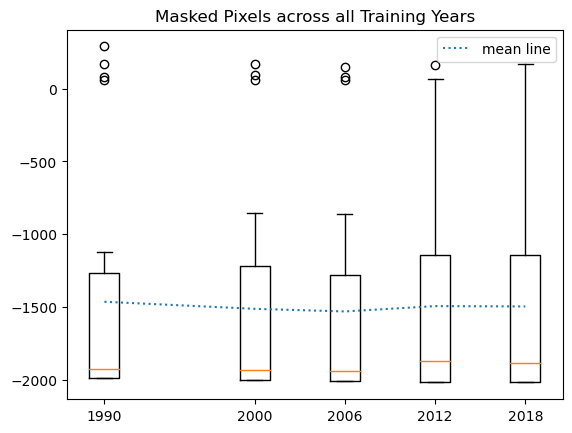

In [223]:
fig,ax = plt.subplots()
#ax.set_xticks(list(np.arange(1984, 2022)), list(np.arange(1984, 2022)))
groups = classArea_df.groupby((   'training', 'year_trained'))
ls = []
means = []
for year in year_classified:
    y = groups.get_group(year)[('area_RF',     '6')].values
    ls.append(y)
    means.append(np.mean(y))
ax.boxplot(ls, positions=year_classified, widths=2, meanline=True)
ax.plot(year_classified, means, ls=':', label='mean line')
# ax.set_ylim(0.6, 0.9)
# ax.set_xlim(1984, 2022)
ax.legend()
ax.set_title('Masked Pixels across all Training Years');

In [224]:
groups.get_group(1990)[('area_RF',     '6')].values

array([  170.04494064, -1121.04137693, -1990.        ,   288.9496701 ,
       -1188.77559444, -1507.10129803,    81.80562092, -1990.        ,
          57.5897379 , -1990.        , -1990.        , -1639.97102917,
       -1747.56122536, -1990.        , -1990.        , -1855.4575343 ,
       -1990.        , -1990.        , -1990.        , -1852.2925636 ,
       -1990.        , -1990.        ])

In [304]:
headers = ('catchment', 'year', 'classes')
ranking_classifiers = [ ('la Meuse Stenay', 2012, 4)]
#print(type(headers[0]))
df = pd.DataFrame(ranking_classifiers, columns=headers)#, dtype=[(headers[0], 'U')])#, (headers[1], int()), (headers[2], int())])
df.dtypes

catchment    object
year          int64
classes       int64
dtype: object

In [217]:
Map=geemap.Map()
Map.centerObject(aoi, 10)
Map.addLayer(trainingClassImage, {'band':['landcover'], 'min':1, 'max':5, 'palette':['red', 'yellow', 'green', 'purple', 'blue']}, 'Train on')
Map.addLayer(imageToClassify, {'band':['B3', 'B2','B1'], 'min':0, 'max':1200, 'gamma':0.9}, 'RGB')
Map.addLayer(classified, {'band':['landcover'], 'min':1, 'max':5, 'palette':['red', 'yellow', 'green', 'purple', 'blue']}, 'Classified')

Map

Map(center=[49.77390824509992, 4.868050388133598], controls=(WidgetControl(options=['position', 'transparent_b…

In [120]:
def maskedPixelCount(image, band, geom, scale):
    im = image.select(band)
    Pix = im.reduceRegion(**{
                                'reducer':ee.Reducer.count(),
                                'geometry':geom,
                                'scale':im.projection().nominalScale(),
                                'crs':im.projection(),
                                'maxPixels':1e9,
                                }).get(band)
    unmaskPix = im.unmask(1).reduceRegion(**{
                                'reducer':ee.Reducer.count(),
                                'geometry':geom,
                                'scale':im.projection().nominalScale(),
                                'crs':im.projection(),
                                'maxPixels':1e9,
                                }).get(band)
    maskedPix = ee.Number(unmaskPix).subtract(ee.Number(Pix))
    return [Pix.getInfo(), unmaskPix.getInfo(), maskedPix.getInfo()]

def pixelToArea(pixels, scale):
    '''
    x [pixels] * y [sqm / pixel]
    --------------------------   = area [sq km]
        z [sqm / sqkm]
    '''
    return (pixels*scale)/1e6

In [284]:
pix1, unmaskPix1, maskedPixels1 = maskedPixelCount(imageToClassify, 'B1', aoi, 30)
pix2, unmaskPix2, maskedPixels2 = maskedPixelCount(classified, 'classification', aoi, 30)
pix3, unmaskPix3, maskedPixels3 = maskedPixelCount(trainingClassImage, 'landcover', aoi, 30)

1589.5336892619698

In [216]:
areaBand = ee.Image.pixelArea().divide(1e6)
image = classified.addBands(areaBand)

areas = image.select('area').reduceRegion(**{
        'reducer':ee.Reducer.sum(),
        'geometry':aoi,
        'scale':30,
        # 'crs':'EPSG:3035',
        'maxPixels':1e13,
        'bestEffort':True,
})

areas
#classAreasLists = classAreas.map(extractArea) #6191.08

In [206]:
(classAreas.getInfo() / 253 )

1579.1635123614628

In [268]:
ca = classArea(trainingClassImage, 100).getInfo()

# print('masked pixels in LS composite, area in sqKm:', pixelToArea(maskedPixels1, 30))

print('masked pixels in classified, area in sqKm:', pixelToArea(maskedPixels2, 30))

print('masked pixels in training, area in sqKm:', pixelToArea(maskedPixels3, 30))

In [283]:
df.area_CORINE.sum(axis=1)

date
2011-08-31 22:00:00    1589.539192
dtype: float64

In [263]:
df.year_trained

date
2011-08-31 22:00:00    2011
Name: year_trained, dtype: int64

In [ ]:
chart_min_region = chart.Image.series(**{
'imageCollection': clear_collection,
'reducer': ee.Reducer.min(),
'region': aoi,
'scale': scale,
'band': 'B1_min',
}).dataframe
chart_min_region

In [ ]:
Map.addLayer(imcol.first(), RGB_VIS, '')
Map.centerObject(aoi, 10)
Map

In [ ]:
def plot_band_timeseries(annual_df ,  bands=[], percentile=False, decadal= True, separate=False):
    fignum = 0
    for i in bands:
        if separate == True:
            fignum+=1
        plt.figure(fignum)
        df = annual_df.loc[:,i]
        #display(df)
        
        plt.title(f'{bands} Timeseries')
        
        c = 'blue'
        fill  = 'grey'
        
        
        
        if i == 'B1':
            c = 'blue'
            fill  = c
        
        if i == 'B2':
            c = 'green'
            fill  = c
        
        if i == 'B3':
            c = 'red'
            fill=c
            
        if i == 'gndvi':
            c = 'green'
            fill  = c
        
        df.plot(figsize=(20, 10), color=c)
        
        if decadal == True:
            
            decadal_mean = df.rolling(10).mean()
            decadal_mean.plot(c='red', linestyle='dashed', label=f'Decadal Mean {i}')
            plt.axvline(annual_df.index[0], linestyle='dotted')
            plt.scatter(annual_df.index[9], decadal_mean[9], label=f'{i} mean 1984-1993')
            plt.axvline(annual_df.index[9], linestyle='dotted')
            plt.scatter(annual_df.index[19], decadal_mean[19], label=f'{i} mean 1994-2003')
            plt.axvline(annual_df.index[19], linestyle='dotted')
            plt.scatter(annual_df.index[29], decadal_mean[29], label=f'{i} mean 2004-2013')
            plt.axvline(annual_df.index[29], linestyle='dotted')
        
        if percentile == True:
            df_5 = annual_df.loc[:,f'{i}p5']
            df_95 = annual_df.loc[:,f'{i}p95']
            
            df_5.plot(color='black', linestyle='dashed', alpha=0.7, label=f'{i} p0.05')
            df_95.plot(color='black', linestyle='dashed', alpha=0.7, label=f'{i} p0.95')
            plt.fill_between(annual_df.index, df_5, df_95, color=fill, alpha=0.2)
            plt.title(f'{bands} Timeseries With Decadal Mean and Percentile Bands')
        

        # Add axis labels and a legend
        plt.xlabel('Year')
        
        plt.ylabel(f'mean surface reflectance / $km^2$')
        
        plt.suptitle('La Meuse Stenay 1984 - 2022')
        
        

        #plt.ylim(df.min() - (df.min()*0.7), df.max()*1.2,)
        plt.legend()

plot_band_timeseries(annual, ['ndvi', 'gndvi'], decadal=False)


In [ ]:
fignum+=1
plt.figure(fignum)
#annual.ndvi.plot(figsize=(20, 10), c='blue')
decadal_mean = annual.ndvi.rolling(10).mean()
decadal_mean.plot(figsize=(20, 10), c='red', label='Decadal Mean')
#annual.ndvip5.plot(color='black', linestyle='dashed', alpha=0.7, label='NDVI p0.05')
#annual.ndvip95.plot(color='black', linestyle='dashed', alpha=0.7, label='NDVI p0.95')
plt.fill_between(annual.index, annual.ndvip5, annual.ndvip95, color='grey', alpha=0.2)
plt.axvline(annual.index[0], linestyle='dotted')
plt.scatter(annual.index[9], decadal_mean[9], label='NDVI mean 1984-1993')
plt.axvline(annual.index[9], linestyle='dotted')
plt.scatter(annual.index[19], decadal_mean[19], label='NDVI mean 1994-2003')
plt.axvline(annual.index[19], linestyle='dotted')
plt.scatter(annual.index[29], decadal_mean[29], label='NDVI mean 2004-2013')
plt.axvline(annual.index[29], linestyle='dotted')

# Add axis labels and a legend
plt.xlabel('Year')
plt.ylabel('NDVI [$/km^2$]')

plt.suptitle('La Meuse Stenay 1984 - 2022')
plt.title('NDVI Timeseries With Decadal Mean and Percentile Bands')

plt.ylim(0.55,0.75)
plt.xlim(annual.index[8], annual.index[32])
plt.legend()


In [ ]:
annual

## Trend analysis per band

- can we look at median band collection and percentile bounds, reduced to a per kilometer scale

In [ ]:
stats_LS = geemap.image_stats(LS, aoi, scale=scale)
LS_col_stats = stats_LS.getInfo()
print(LS_col_stats)

***
<a id="Land_Cover"></a>
## Land Cover 

[Linking Reference to Land Cover](#Land_cover)

In [ ]:
Map = geemap.Map()
Map.add_basemap('HYBRID')
Map.addLayer(aoi, {}, 'ROI')
Map.centerObject(aoi, 12)
Map